# Lennard Jones gas in NTV ensemble

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import time

In [2]:
# Parameter
# all in reduced units
N=100
T=1.5
beta=1./T
rho=0.9
V=N/rho
L=V**(1/3)
print(rho,L,V)

0.9 4.807498567691361 111.11111111111111


In [3]:
#distance in periodic boundary conditions
def norm_pb(_x,_y):
    return(norm(_x-(_y+L*np.rint((_x-_y)/L))))
    
#Lennard Jones potential truncated 
rc=2.5
def u(i,j,r_c=rc):
    r=norm_pb(i,j)
    if r>r_c: 
        return 0.
    else:        
        return 4*((1/r)**(12)-(1/r)**6)

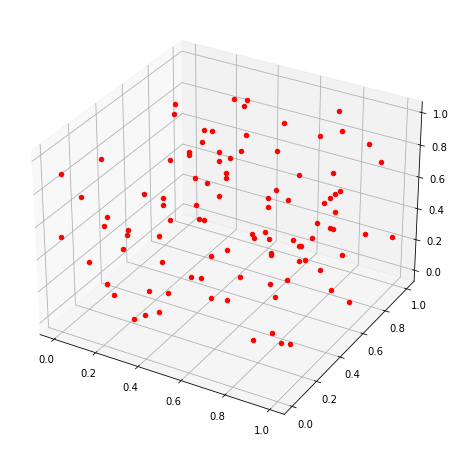

In [4]:
pos=[np.random.random(3) for i in range(N)]
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(projection='3d')
for x,y,z in pos:
    ax.scatter(x,y,z,'.',c='red')

In [5]:
#Verlet list

rv=2.7

##Creation of the list
def verl_list():
    ver=[[]for i in range(N)]
    for i in range(N-1):
        for j in range(i+1,N):
            if norm_pb(pos[i],pos[j])<rv:
                ver[i].append(j)
                ver[j].append(i)
                
    return ver
posv=pos.copy()
ver=verl_list()

In [6]:
#Energy evaluation
## for single
def en_verl(i,k,ver):
    ev=0.
    for j in ver[i]:
        ev+=u(k,pos[j])/N
    return ev

#total energy
def e_tot_v():
    e_v=0
    for i in range(N):
        e_v+=en_verl(i,pos[i],ver)*0.5
    return e_v

#classical way
def en(_pos=pos):
    e_p=0
    for i in range(N-1):
        for j in range(i+1,N):
                e_p+=u(_pos[i],_pos[j])/N
    return(e_p)

#show they are the same 
print(e_tot_v(),en())
e=e_tot_v()

7812765058880815.0 7812765058880738.0


In [7]:
def mcmove_verl(ver,posv,step=0.1):
    #choose particle
    for i in range(N):
        p=np.random.randint(N)
        
        if norm_pb(pos[p],posv[p])>=(rv-rc)*0.5:
            ver=verl_list()
        
        xi=(pos[p]+(-0.5+np.random.random(3))*step+L)%L
        e0=en_verl(p,pos[p],ver)
        
        if norm_pb(xi,posv[p])>=(rv-rc)*0.5:
            ver=verl_list()
            
        delta=en_verl(p,xi,ver)-e0
        
        if(np.random.random()<min(1,np.exp(-beta*delta))):
            pos[p]=xi
            posv[p]=xi
            
    return(ver.copy(),posv.copy())   

In [8]:
#dummy algorithm for montecarlo move
def mcmove_dum(e,_pos=pos,step=0.2):
    for i in range(N):
        p=np.random.randint(N)
        pos2=_pos.copy()
        pos2[p]=(pos[p]+(-0.5+np.random.random(3))*step+L)%L
        delta=en(pos2)-e
        if(np.random.random()<min(1,np.exp(-delta*beta))):
            _pos[p]=pos2[p]
            e+=delta
    return(e,_pos)

In [11]:
Te=100

file='pos_'+str(N)+'_'+str(rho)+'.txt'
efile='energy_'+str(N)+'_'+str(rho)+'.txt'

data=np.loadtxt(file)
ts=int(data.shape[0]/N)
data=data.reshape((ts,N,3))
pos=data[-1]
del(data)

eli=False
if eli:
    os.remove(file)
    os.remove(efile)
    
"""
open(file,"w").close()
f=open(file,'a')

open(efile,"w").close()
g=open(efile,'a')
#em=e/Te
l=0

for t in range(Te):
    ver,posv=mcmove_verl(ver.copy(),posv.copy(),0.05)
    if (t//10)>l:
        np.savetxt(f,pos)
        f.write('\n')
        g.write(f'{t} {e_tot_v()}\n')
        l+=1
    print("Loading " + str(int((t+1)/Te*100))+'%',end="\r")
f.close()
g.close()
"""

'\nopen(file,"w").close()\nf=open(file,\'a\')\n\nopen(efile,"w").close()\ng=open(efile,\'a\')\n#em=e/Te\nl=0\n\nfor t in range(Te):\n    ver,posv=mcmove_verl(ver.copy(),posv.copy(),0.05)\n    if (t//10)>l:\n        np.savetxt(f,pos)\n        f.write(\'\n\')\n        g.write(f\'{t} {e_tot_v()}\n\')\n        l+=1\n    print("Loading " + str(int((t+1)/Te*100))+\'%\',end="\r")\nf.close()\ng.close()\n'

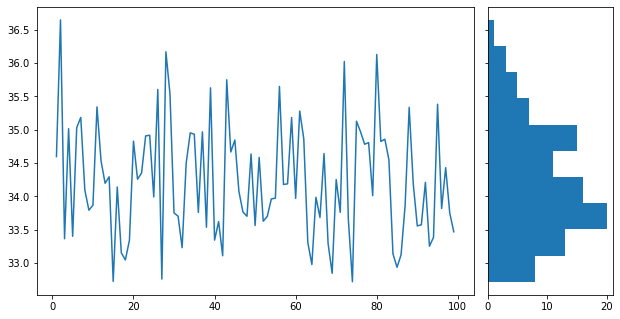

In [12]:
#plot temporal evolution of the energy and the histogram
te,E=np.loadtxt(efile,unpack=True)
fig=plt.figure(figsize=(10,5))
gs=fig.add_gridspec(1,2,width_ratios=(7, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
ax.plot(te,E)
ax_histy.hist(E,orientation='horizontal')
ax_histy.tick_params(axis="y", labelleft=False)

# Radial Distribution Function

In [13]:
dr=0.07
R=7
nh=np.int((R+dr)/dr)
rr=np.linspace(0,R,nh+1)
delg=L/(2*nh)

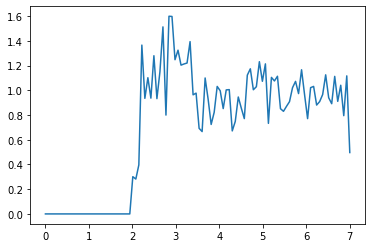

In [17]:
g=np.zeros(nh+1)
ng=0

def add_data(g,n_g=ng):
    for i in range(N-1):
        for j in range(i+1,N):
            r=norm_pb(pos[i],pos[j])
            #r=norm(pos[i]-pos[j])
            if r<L/2:
                ig=np.rint(r/delg).astype(int)
                g[ig]+=2
    return(n_g+1)

def g_r(g,ng):
    G=g.copy()
    for i in range(len(G)):
        r=delg*(i+0.5)
        vb=((i+1)**3-i**3)*(delg**3)
        nid=4/3*np.pi*vb*rho
        G[i]=G[i]/(N*nid*ng)
    return G

ng=add_data(g,ng)
gg=g_r(g,ng)
plt.plot(rr,gg[:],'-')

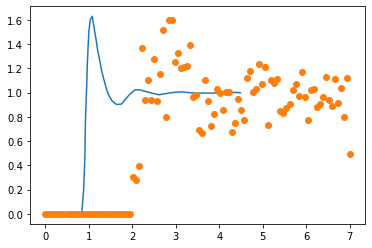

In [18]:
# comparison between the real and mine
(R,G)=np.loadtxt('radial_2.csv',delimiter=',',unpack=True)
plt.plot(R,G)
plt.plot(rr,gg[:],'o')

In [ ]:
data=np.loadtxt(file)
t_s=int(data.shape[0]/N)
data=data.reshape((t_s,N,3))

In [ ]:
for i in range(0,data.shape[0]):
    pos=data[i,:,:]
    ng=add_data(g,ng)
del(data)

In [ ]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot()
ax.plot(rr,gg[:],'.-',label='Simulation')
ax.set_ylabel(r'$g(r)$')
ax.set_xlabel(r'$r$')
ax.legend(frameon=False)
#fig.savefig('g_T_'+str(T)+'_rho_'+str(rho)+'_N_'+str(N)+'.png')

In [ ]:
#Try evaluate energy using 
def u_r(r,_rc=rc):
    if r<rc
        return 4*((1/r)**12-(1/r)**6)
    else:
        return 0
    
print(e_tot_v(),2*np.pi*rho*np.trapz(rr[1:]*rr[1:]*g[1:]*u_r(rr[1:])))